In [88]:
import os
import getpass
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from qdrant_client import QdrantClient
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_community.document_compressors import JinaRerank
from langchain.retrievers import ContextualCompressionRetriever
from langchain.vectorstores import Qdrant
from langchain.embeddings import FastEmbedEmbeddings
from langchain.chains import RetrievalQA

from src.base.llm import SingletonChatLLM

In [ ]:
%pip install langgraph
%pip install jina

In [99]:
# Load environment variables
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
os.environ["JINA_API_KEY"] = os.getenv("JINA_API_KEY")


In [100]:
from langgraph.graph import MessagesState
from typing import Literal
from typing_extensions import TypedDict

# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str


chat_model = SingletonChatLLM(llm_name='CHAT_GROQ').get_llm()

# Định nghĩa các agent cần thiết
members = ["product1_assistant", "product2_assistant", "customer_care"]

options = members + ["FINISH"]

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

system_prompt = (
    # "You are a supervisor tasked with managing a conversation between the"
    # f" following workers: {members}. Given the following user request,"
    # " respond with the worker to act next. Each worker will perform a"
    # " task and respond with their results and status. When finished,"
    # " respond with FINISH."
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Based on the user request:"
    "\n- If the request contains 'lt4670', route to 'product1_assistant'."
    "\n- If the request contains 'bc289', route to 'product2_assistant'."
    "\n- Otherwise, route to 'customer_care'."
    "\nEach worker will perform a task and respond with their results and status."
    " When finished, respond with 'FINISH'."
)

# Define the supervisor node and agent states
def supervisor_node(state: AgentState) -> AgentState:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = chat_model.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END
    return {"next": next_}




In [132]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

In [129]:
custom_prompt_template = """You are a helpful assistant, You must use japanese to answer the question, conversing with a user about the subjects contained in a set of documents.
Use the information from the DOCUMENTS section to provide accurate answers. If unsure or if the answer
isn't found in the DOCUMENTS section, simply state that you don't know the answer.

Documents:
{context}

Question:
{question}

Answer:
"""

def set_custom_prompt():
    """
    Prompt template for QA retrieval for each vectorstore
    """
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    return prompt


client = QdrantClient(api_key=QDRANT_API_KEY, url=QDRANT_URL,)

from langchain_community.document_compressors import JinaRerank
from langchain.retrievers import ContextualCompressionRetriever

os.environ["JINA_API_KEY"] = os.getenv("JINA_API_KEY")
def retrieval_qa_chain(llm, prompt, vectorstore):
    retriever = vectorstore.as_retriever(search_kwargs={'k': 2})
    compressor = JinaRerank()
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=retriever
    )
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=compression_retriever,
        return_source_documents=True,
        chain_type_kwargs={'prompt': prompt}
    )
    return qa_chain


def qa_bot():
    embeddings = FastEmbedEmbeddings()
    vectorstore = Qdrant(client=client, embeddings=embeddings, collection_name="rag2")
    llm = chat_model
    qa_prompt=set_custom_prompt()
    qa = retrieval_qa_chain(llm, qa_prompt, vectorstore)
    return qa

In [137]:
#RAG Chain
rag_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\n

     <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUESTION: {question} \n
    CONTEXT: {context} \n
    Answer:
    <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question","context"],
)

embeddings = FastEmbedEmbeddings()
vectorstore = Qdrant(client=client, embeddings=embeddings, collection_name="rag2")
llm = chat_model
retriever = vectorstore.as_retriever(search_kwargs={'k': 2})
compressor = JinaRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

rag_prompt_chain = rag_prompt | llm | StrOutputParser()

QUESTION = """LT4670?"""
CONTEXT = compression_retriever.invoke(QUESTION)

result = rag_prompt_chain.invoke({"question": QUESTION, "context":CONTEXT})

print(result)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 54899.27it/s]


LT4670 is a 1U full rack-size sync generator that outputs analog video sync signals and audio word clock.  It supports various output formats including PTP, GNSS, IP, SDI (4K/HD/3G/SD), AES/EBU, LTC, and analog sync signals. 



In [141]:
qa = qa_bot()
# response = qa({"query": "how to setup HDR display?"})
response = qa("how to setup HDR display?")
print(response)
response['result']

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 23669.89it/s]


{'query': 'how to setup HDR display?', 'result': 'HDR表示の設定方法については、以下の手順で操作できます。\n\n1. PICボタンを押します。\n2. F2 (CINELITE/HDR) を選択します。\n3. F5 (HDR ZONE) を選択し、表示をONまたはOFFに切り替えます。 \n\n\n\n', 'source_documents': [Document(metadata={'source': 'data2/output.md', '_id': '56d3049c-c375-4f8d-9fc8-ddffaf27c384', '_collection_name': 'rag2', 'relevance_score': 0.40686196088790894}, page_content='具体的な操作手順は以下の通りです：\n\nPICボタンを押す。\n\nF2 (CINELITE/HDR)を選択。\n\nF5 (HDR ZONE)を選択し、表示をOFFまたはONに切り替える。\n\nこの操作により、HDRの測定や評価がより直感的に行えるようになります。シネゾーン表示は、HDRコンテンツの制作や評価において、視覚的な情報を提供するための重要なツールです。\n\n図には、シネゾーン表示のインターフェースや設定が示されており、具体的な操作や表示内容が視覚的に理解できるようになっています。 このページでは、HDR測定における基準レベルの設定方法について説明されています。HDRタブのVARIABLEがONの状態で、基準レベルを可変にすることができ、これはSDR表示とHDR表示の境界線を示します。\n\n具体的な操作手順は以下の通りです：\n\nPIC ➡ F2 (CINELITE/HDR) ➡ F2 (CINEZONE SETUP) ➡ F4 (REF [%]): ここで基準レベルを0.0から100.0の範囲で設定します。\n\n画面左上には、F2 (UPPER [%])、F3 (LOWER [%])、F4 (REF [%])で設定した値のHDR換算値が表示されます。\n\n表示される情報には、以下のようなデータが含まれています： - Upper: 100.0 cd/m² - Lower: 50.7 cd/m

'HDR表示の設定方法については、以下の手順で操作できます。\n\n1. PICボタンを押します。\n2. F2 (CINELITE/HDR) を選択します。\n3. F5 (HDR ZONE) を選択し、表示をONまたはOFFに切り替えます。 \n\n\n\n'

In [159]:
# Define the QA agent nodes
def qa_product1_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content

    result = qa({"query": user_input})

    response = result['result']

    return {
        "messages": [response]
    }

In [160]:
def qa_product2_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content

    result = qa({"query": user_input})

    response = result['result']

    return {
        "messages": response
    }

In [161]:
def qa_customer_care_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content

    result = qa({"query": user_input})

    response = result['result']

    return {
        "messages": response
    }

In [162]:
def supervisor(state: AgentState):
    """
    Supervises the workflow and decides which agent to call based on the question.
    """
    # Simple logic to route based on product name in the question
    user_query = state["messages"][-1].content.lower()
    print(user_query)

    if "lt4670" in user_query:
        return {"next": "qa_product1_agent_node"}
    elif "lxm3" in user_query:
        return {"next": "qa_product2_agent_node"}
    else:
        return {"next": "qa_customer_care_agent_node"}

In [163]:
# Setup the agent state graph and add conditional edges
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("product1_assistant", qa_product1_agent_node)
builder.add_node("product2_assistant", qa_product2_agent_node)
builder.add_node("customer_care", qa_customer_care_agent_node)
# # === Graph Setup ===
# builder = StateGraph(AgentState)
# builder.add_node(supervisor)
# builder.add_node(qa_product1_agent_node)
# builder.add_node(qa_product2_agent_node)
# builder.add_node(qa_customer_care_agent_node)

# builder.add_edge(START, "supervisor")
# builder.add_conditional_edges("supervisor", lambda state: state["next"])
builder.add_edge("product1_assistant", "__end__")
builder.add_edge("product2_assistant", "__end__")
builder.add_edge("customer_care", "__end__")

# for member in members:
#     builder.add_edge(member, "supervisor")

builder.add_conditional_edges("supervisor", lambda state: state["next"])

# Compile the graph and execute it
graph = builder.compile()



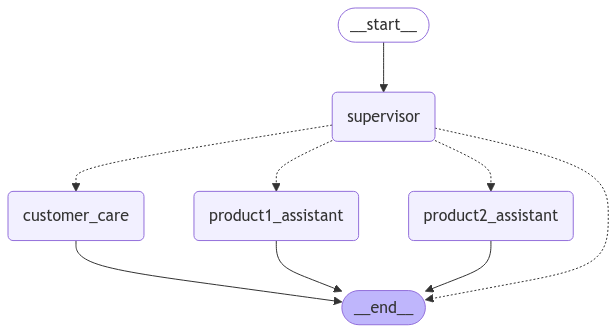

In [109]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [158]:
for s in graph.stream(
    {"messages": [("user", "lt4670: How to configure the HDR display?")]}
):
    print(s)
    print("----")

# for s in graph.stream(
#     {"messages": [("user", "how are you")]}
# ):
#     print(s)
#     print("----")

# res = graph.invoke({"messages": [("user", "lt4670: How to configure the HDR display?")]})

{'supervisor': {'next': 'product1_assistant'}}
----
{'product1_assistant': {'messages': ['LT4670のHDR表示の設定方法について説明します。\n\n1. **PICボタンを押します。**\n2. **F2 (CINELITE/HDR) を選択します。**\n3. **F2 (CINEZONE SETUP) を選択します。**\n4. **F4 (REF [%]) を選択し、基準レベルを0.0から100.0の範囲で設定します。**\n\nこれでHDRの測定や評価がより直感的に行えるようになります。 \n\n\n']}}
----


In [164]:
%pip install streamlit

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached pyarrow-18.0.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (3.3 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 333.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 280.8 kB/s eta 0:00:00a 0:00:01
Using cached cachetools-5.5.0-py3-none-any.whl (9.5 kB)
Using cached pyarrow-18.0.0-cp312-cp312-macosx_12_0_arm64.whl (29.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 344.6 kB/s eta 0:00:0000:0100:02
Using cached rich-13.9.4-py3-none-any.whl (242 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upg

In [165]:
import streamlit as st
from langchain_core.messages import AIMessage, HumanMessage

# Constants
height = 600
title = "Multi-Agent Software Team (LangGraph)"
icon = ":robot:"

def generate_message(user_input):
    response = graph.invoke({"messages": [HumanMessage(content=user_input)]})
    ai_messages = [msg for msg in response["messages"] if isinstance(msg, AIMessage)]

    st.session_state.conversation.append({
        "user": user_input,
        "assistant": ai_messages[-1].content,
    })

    # Iterate over the conversation history
    for entry in st.session_state.conversation:
        messages.chat_message("user", avatar="img/user.png").write(entry['user'])
        messages.chat_message("ai", avatar="img/summary.png" ).write("**assistant:** \n" + entry['assistant'])

# Session: Initialize conversation history
if "conversation" not in st.session_state:
    st.session_state.conversation = []

# Set page title and icon
st.set_page_config(page_title=title, page_icon=icon)
st.header(title)

# Create a container for the chat messages
messages = st.container(border=True, height=height)

# Chatbot UI
if prompt := st.chat_input("Enter your question...", key="prompt"):
    generate_message(prompt)

2024-11-21 01:19:41.395 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 01:19:41.395 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2024-11-21 01:19:41.395 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 01:19:41.396 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 01:19:41.434 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 01:19:41.435 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

In [ ]:
while True:
  user_input=input("User: ")
  if user_input.lower() in ["quit","q"]:
    print("Good Bye")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    print(event.values())
    # Chuyển dict_values thành danh sách

    # # Truy cập tin nhắn
    # messages = response_list[0]['messages']

    # # Lấy nội dung từ HumanMessage
    # for message in messages:
    #     print(message.content)

dict_values([{'next': 'customer_care'}])
dict_values([{'messages': [HumanMessage(content=['こんにちは！ \n'], additional_kwargs={}, response_metadata={}, name='customer_care', id='ab0b82e7-7ca1-4a6f-b060-67d3c45ccd2d')]}])


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "Router"\n\t\t},\n\t\t"parameters": {\n\t\t\t"next": "pending"\n\t\t}\n\t}\n}\n</tool-use> \n'}}

In [ ]:
res1 = graph.invoke({"messages": [("user", "how are you")]})
print(res['messages'][-1].content)
print("----")

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "Router"\n\t\t},\n\t\t"parameters": {\n\t\t\t"next": "pending"\n\t\t}\n\t}\n}\n</tool-use> \n'}}

In [ ]:
res = graph.invoke({"messages": [("user", "now, what time is it?")]})
print(res['messages'][-1].content)
print("----")

In [ ]:


# Initialize Qdrant client
client = QdrantClient(api_key=QDRANT_API_KEY, url=QDRANT_URL)

# Initialize chat model (Groq)
chat_model = SingletonChatLLM(llm_name='CHAT_GROQ').get_llm()

# Define a custom prompt template for the QA retrieval process
custom_prompt_template = """You are a helpful assistant. You must use Japanese to answer the question, conversing with a user about the subjects contained in a set of documents.
Use the information from the DOCUMENTS section to provide accurate answers. If unsure or if the answer isn't found in the DOCUMENTS section, simply state that you don't know the answer.

Documents:
{context}

Question:
{question}

Answer:
"""

def set_custom_prompt():
    """Setup prompt template for each QA agent."""
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    return prompt

# Function to create a QA chain using retrieval from Qdrant
def retrieval_qa_chain(llm, prompt, vectorstore):
    retriever = vectorstore.as_retriever(search_kwargs={'k': 2})
    compressor = JinaRerank()
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=retriever
    )
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=compression_retriever,
        return_source_documents=True,
        chain_type_kwargs={'prompt': prompt}
    )
    return qa_chain

# Initialize embeddings
embeddings = FastEmbedEmbeddings()

# Query Qdrant collection
def query_qdrant_collection(collection_name: str, query_vector: list):
    """Query data from Qdrant based on the search vector."""
    result = client.search(collection_name=collection_name, query_vector=query_vector, limit=5)
    return result

# Define the QA agent nodes
def qa_product1_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content
    prompt = set_custom_prompt()

    # Generate query vector for search (you should replace this with actual vector generation logic)
    query_vector = [0.1, 0.2, 0.3]
    result = query_qdrant_collection("product1_collection", query_vector)

    qa_chain = retrieval_qa_chain(chat_model, prompt, Qdrant(client=client, embeddings=embeddings, collection_name="product1_collection"))
    response = qa_chain.run(input={"question": user_input, "context": result})

    return {
        "messages": [HumanMessage(content=f"Câu trả lời cho sản phẩm 1: {response}", name="product1")]
    }

def qa_product2_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content
    prompt = set_custom_prompt()

    query_vector = [0.4, 0.5, 0.6]
    result = query_qdrant_collection("product2_collection", query_vector)

    qa_chain = retrieval_qa_chain(chat_model, prompt, Qdrant(client=client, embeddings=embeddings, collection_name="product2_collection"))
    response = qa_chain.run(input={"question": user_input, "context": result})

    return {
        "messages": [HumanMessage(content=f"Câu trả lời cho sản phẩm 2: {response}", name="product2")]
    }

def qa_customer_care_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content
    prompt = set_custom_prompt()

    query_vector = [0.7, 0.8, 0.9]
    result = query_qdrant_collection("customer_care_collection", query_vector)

    qa_chain = retrieval_qa_chain(chat_model, prompt, Qdrant(client=client, embeddings=embeddings, collection_name="customer_care_collection"))
    response = qa_chain.run(input={"question": user_input, "context": result})

    return {
        "messages": [HumanMessage(content=f"Câu trả lời chăm sóc khách hàng: {response}", name="customer_care")]
    }

# Define the supervisor node and agent states
def supervisor_node(state: AgentState) -> AgentState:
    system_prompt = (
        "You are a supervisor tasked with managing conversations for the following workers: {members}. "
        "Given the following user request, respond with the worker to act next. Each worker will perform a task "
        "and respond with their results and status. When finished, respond with FINISH."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = chat_model.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END
    return {"next": next_}

# Setup the agent state graph and add conditional edges
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("product1", qa_product1_agent_node)
builder.add_node("product2", qa_product2_agent_node)
builder.add_node("customer_care", qa_customer_care_agent_node)

for member in members:
    builder.add_edge(member, "supervisor")

builder.add_conditional_edges("supervisor", lambda state: state["next"])

# Compile the graph and execute it
graph = builder.compile()

for s in graph.stream(
    {"messages": [("user", "Cấu hình sản phẩm 1 như thế nào?")]}, subgraphs=True
):
    print(s)
    print("----")
